# Board games and an exploration of how people feel about them
### IST-652, December 2023
### Sana Khan, Ian Murphy, & Joanna Herron
<br>
In this notebook, we begin by taking a look at a dataset (sourced from Board Game Geek via Kaggle) containing a list of over 10,000 board games, qualitative and quantitative information about them, and user ratings. We look at the top titles and designers and what types of games have been most often published throughout the past several decades, and try to get a feel for what exactly makes a game good or bad. We also utilize Reddit's API to dig into a selection of the most discussed games and conduct a sentiment analysis (based on work done by Temidayo Omoniyi, found on medium.com) to see if the Board Game Geek ratings hold up against real-life impressions. 

We begin by loading up the packages needed for our analyses and importing the file into our environment, then take a look at what we've got to work with. 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords') #if this download doesn't work, use the next line with corpus instead 
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

#import data set
SOURCE_FILE = 'board_games_project.csv'
BGG_data = pd.read_csv(SOURCE_FILE)#.set_index('game_id')



[nltk_data] Downloading package stopwords to /Users/gozi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import percentileofscore


In [64]:
#pip install textblob


In [65]:
#pip install praw


In [78]:
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from textblob import TextBlob

In [5]:
#Peek at base dataset
BGG_summary = pd.DataFrame(BGG_data.dtypes,BGG_data.columns)
BGG_summary['n values'] = BGG_data.nunique()
BGG_summary['nulls'] = BGG_data.isnull().sum() 
BGG_summary

,0,n values,nulls
game_id,int64,10532,0
description,object,10528,0
image,object,10527,1
max_players,int64,48,0
max_playtime,int64,83,0
min_age,int64,22,0
min_players,int64,10,0
min_playtime,int64,74,0
name,object,10357,0
playing_time,int64,83,0


## Phase 1: Qualitative Analysis
<br>
For this piece of the puzzle, we whittle down the dataframe to primarily qualitative information so we can take a look at the flavors of popular games and what trends there have been over time. 

In [18]:
#Drop quantitative fields we don't need right now
BGG_data.drop(['image','thumbnail','max_players','max_playtime','min_age','min_players','min_playtime','playing_time','artist','compilation','expansion','publisher'],  axis=1, inplace=True)

#Create a decade field to use for grouping
BGG_data['decade_published'] = BGG_data['year_published']-(BGG_data['year_published']%10)
BGG_data.head()

,game_id,description,name,year_published,category,designer,family,mechanic,average_rating,users_rated,category_list,decade_published
0,1,Die Macher is a game about seven sequential po...,Die Macher,1986,"Economic,Negotiation,Political",Karl-Heinz Schmiel,"Country: Germany,Valley Games Classic Line","Area Control / Area Influence,Auction/Bidding,...",7.66508,4498,"[Economic, Negotiation, Political]",1980
1,2,Dragonmaster is a trick-taking card game based...,Dragonmaster,1981,"Card Game,Fantasy","G. W. ""Jerry"" D'Arcey",Animals: Dragons,Trick-taking,6.60815,478,"[Card Game, Fantasy]",1980
2,3,"Part of the Knizia tile-laying trilogy, Samura...",Samurai,1998,"Abstract Strategy,Medieval",Reiner Knizia,"Asian Theme,Country: Japan,Knizia tile-laying ...","Area Control / Area Influence,Hand Management,...",7.44119,12019,"[Abstract Strategy, Medieval]",1990
3,4,When you see the triangular box and the luxuri...,Tal der Könige,1992,Ancient,Christian Beierer,"Country: Egypt,Promotional Board Games","Action Point Allowance System,Area Control / A...",6.60675,314,[Ancient],1990
4,5,"In Acquire, each player strategically invests ...",Acquire,1964,Economic,Sid Sackson,3M Bookshelf Series,"Hand Management,Stock Holding,Tile Placement",7.35830,15195,[Economic],1960


First, let's give some folks credit by identifying the top game designers in our dataset by the average rating of their games. Admittedly, this would be better to separate by individuals, but for the purpose of those exploration we'll leave the power couples and dream teams as they were. 

In [7]:
#Top n game designers by average rating
def top_designers(n):
    desRatings = pd.DataFrame(round(BGG_data.groupby(['designer'])['average_rating'].mean(),2)).sort_values('average_rating',ascending=False).head(n)
    print(desRatings)

top_designers(10)

                                 average_rating
designer                                       
Adam Poots                                 8.93
Craig Bartell,Tim Flowers                  8.71
Rob Daviau,Matt Leacock                    8.67
Paul Dangel,Mathew Hinkle                  8.63
Robert Butler                              8.62
Terry Doherty                              8.60
Dean Essig,Roland LeBlanc                  8.60
Jens Drögemüller,Helge Ostertag            8.57
Štěpán Štefaník                            8.53
Dean Essig,John Kisner                     8.52


Since we have the publication year for each game, let's see what the top-rated game is from each decade in our dataset. It is interesting to note that the average ratings trend upward in this list. Since these user ratings are from a website, it may stand to reason that a modern, review-posting audience may tend to faver more modern games. 

In [21]:
#Top rated game per decade
idx = BGG_data.groupby(['decade_published'])['average_rating'].transform(max) == BGG_data['average_rating']
BGG_top_by_decade = BGG_data[idx].sort_values('decade_published')
BGG_top_by_decade.loc[:,['year_published','name','average_rating','description']]

,year_published,name,average_rating,description
2567,1956,Eleusis,7.47090,"Eleusis (and later New Eleusis, 1976) is a car..."
2345,1969,A Gamut of Games,7.71089,This book offers rules for thirty-eight games ...
2419,1973,Replay Baseball,7.95183,The new version of the simulation of professio...
4213,1986,Champions of the Galaxy,8.14035,Champions of the Galaxy is a card game combini...
4226,1997,Rivoli 1797,8.02745,"The Battle of Rivoli on January 14th, 1797 bet..."
3225,2003,1844: Switzerland,8.37110,1844 is an 18xx railroad and stock trading gam...
8348,2015,Small World Designer Edition,9.00392,Small World's Designer Edition is a spare-no-e...


Now that we've seen some of the top picks, one begins to wonder what it is that makes a game good? We'll postpone the cold hard numbers for now, and take a more abstract approach to understanding the qualities of a good (or bad) game. Here, we build a function to generate a word cloud based on a number of either the top or bottom-rated games, to make analytical use of a chosen qualitative variable (such as description, family, or mechanic). Two example wordclouds have been generated, but there's endless fun to be had here. 

In [12]:
#Generate word clouds from qualitative variables for n highest- or lowest-rated games of all time
def desc_cloud(topbot,n,col):
    if topbot not in ('top','bottom'):
        print("Please enter either 'top' or 'bottom' for the first parameter")
        return
    else:
        if topbot == 'bottom':
            BGG_topbot_n = BGG_data.sort_values('average_rating').head(n)
        else: 
            BGG_topbot_n = BGG_data.sort_values('average_rating',ascending=False).head(n)
        words = BGG_topbot_n[col].tolist()
        desc_words = []
    for i in words:
        i = str(i).split()
        for j in i:
            desc_words.append(j.lower())
    filtered_words = [j for j in desc_words if j not in [stopwords.words('english'),'quot','&']]
    wc_list = " ".join(filtered_words)
    wordcloud = WordCloud(width=800, height=800, background_color='black', collocations=False, min_font_size=10).generate(wc_list)
    plt.figure(figsize=(6,6), facecolor=None)  
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()



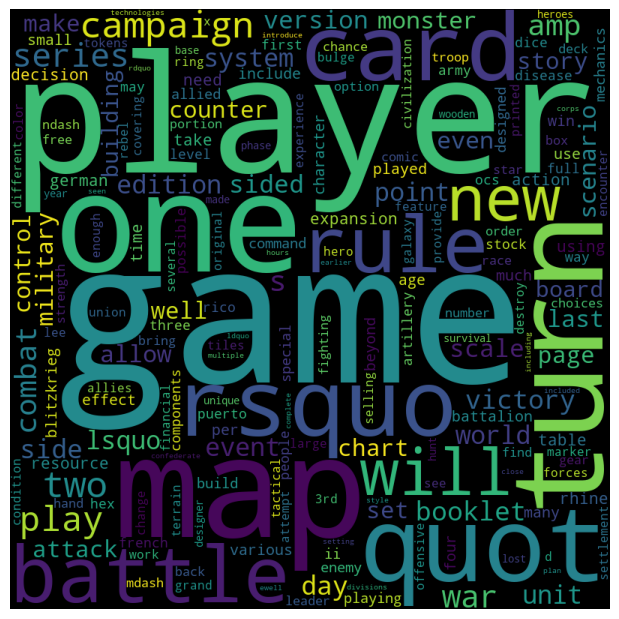

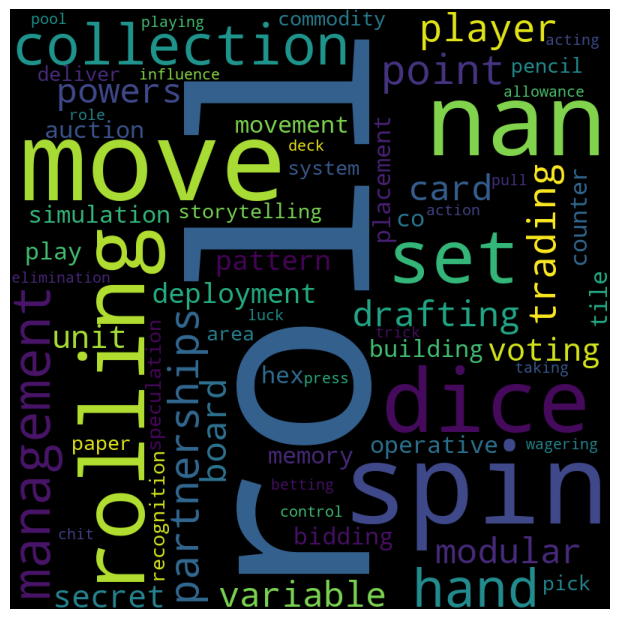

In [13]:
desc_cloud('top',20,'description')
desc_cloud('bottom',100,'mechanic')

The category variable is a bit less freeform than those used above, and thus is our best qualitative candidate for digging into trends. Since games can have multiple categories bundled into one field, we need to first split those up before analysing further. 

In [22]:
#Separate categories into individual fields

BGG_data['category_list'] = BGG_data['category'].str.split(',').fillna('')
BGG_cats = pd.DataFrame(BGG_data['category_list'].tolist()).add_prefix('cat_')
BGG_cat_wide = pd.concat([BGG_data['game_id'], BGG_cats], axis=1)

In [23]:
#Reshape to one row per category and join with the master dataset for analysis

BGG_cat_long = pd.DataFrame(BGG_cat_wide.set_index('game_id').stack())
BGG_cat_long = BGG_cat_long.reset_index()
BGG_cat_long.columns=['game_id','cat_level','cat_desc'] 
BGG_cat_full = BGG_cat_long.set_index('game_id').join(BGG_data.set_index('game_id'))

With the categories more cleanly organized, we can return to our publication years and decades to see what's happened over time. First, we look at the three most common categories of games published in each decade from the 1950s to 2010s. Note that the overall numbers have trended way upwards over the decades. Interestingly, Wargames (and related categories) were in the top 3 for all decades except the 1950s, where simpler games were favored, and the 2010s, where they finally dropped from the top 3. Hopefully that's a good sign for our society!

In [24]:
#Popular categories over time
BGG_cat_full.groupby(['decade_published']).cat_desc.value_counts().groupby(level=0, group_keys=False).head(3)

decade_published  cat_desc         
1950              Children's Game         9
                  Card Game               8
                  Dice                    8
1960              Abstract Strategy      27
                  Card Game              21
                  Wargame                21
1970              Wargame               298
                  World War II           97
                  Science Fiction        55
1980              Wargame               344
                  World War II          101
                  Science Fiction        96
1990              Wargame               396
                  Card Game             368
                  Party Game            123
2000              Card Game            1018
                  Wargame               545
                  Fantasy               371
2010              Card Game            1472
                  Fantasy               627
                  Dice                  441
Name: cat_desc, dtype: int64

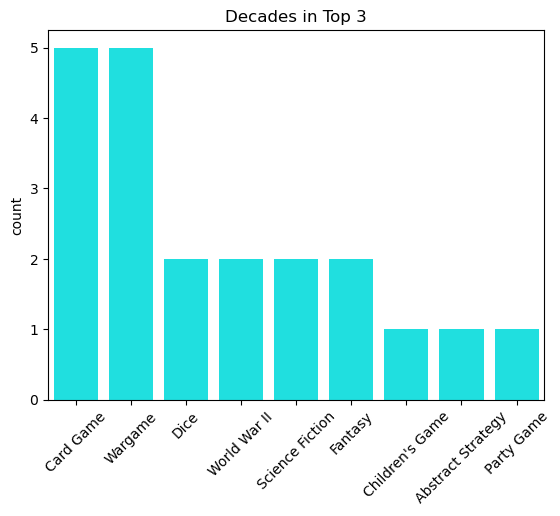

In [30]:

BGG_top_dec_cats = BGG_cat_full.groupby(['decade_published']).cat_desc.value_counts().groupby(level=0, group_keys=False).head(3)
BGG_top_dec_cats = BGG_top_dec_cats.reset_index(name='count')
BGG_top_dec_cats.columns=['decade_published','cat_desc','count'] 
ax = sns.countplot(x='cat_desc', data=BGG_top_dec_cats, color='cyan', order=BGG_top_dec_cats['cat_desc'].value_counts().index)
ax.set_title('Decades in Top 3')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()

After looking at the decade trends, we zoom into the most common categories for each individual year, which adds a bit more flavor. The chart below shows the number of years for which each category was in the top three. 

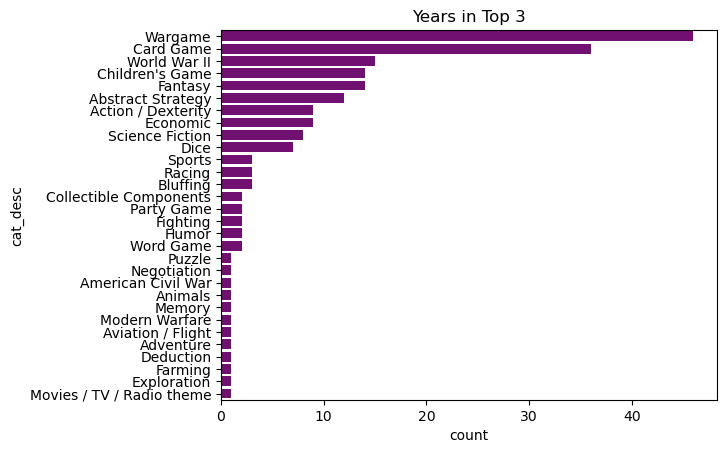

In [31]:
BGG_top_yr_cats = BGG_cat_full.groupby(['decade_published','year_published']).cat_desc.value_counts().groupby(level=1, group_keys=False).head(3)
BGG_top_yr_cats = BGG_top_yr_cats.reset_index(name='count')
BGG_top_yr_cats.columns=['decade_published','year_published','cat_desc','count'] 
#BGG_top_cats
ax = sns.countplot(y='cat_desc', data=BGG_top_yr_cats, color='purple', order=BGG_top_yr_cats['cat_desc'].value_counts().index)
ax.set_title('Years in Top 3')
plt.show()

There are quite a few categories that have been up there in popularity over the years; let's take a look at just the top 10 categories of all time, and see how their publication frequencies have varied. 

<AxesSubplot:xlabel='year_published'>

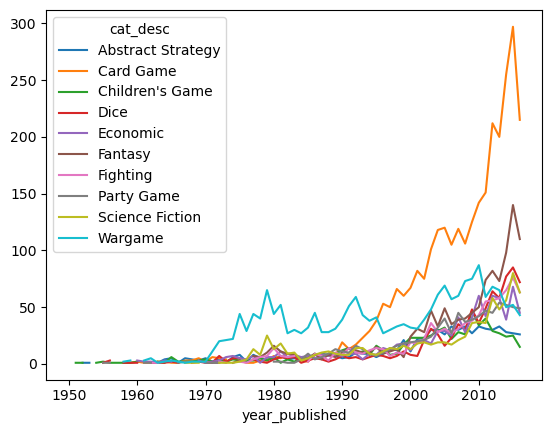

In [32]:
#BGG_cat_long['cat_desc'].nunique() #83 is probably too many to track, let's take 10 from our annual top lists
#identify top 10 categories overall
BGG_top_cats = BGG_cat_long.groupby(['cat_desc'])['game_id'].count()
BGG_top_cats = BGG_top_cats.reset_index()
BGG_top_cats.columns=['cat_desc','freq_overall']
BGG_top_cats = BGG_top_cats.sort_values('freq_overall', ascending=False).head(10)

BGG_top_cats_list = BGG_top_cats['cat_desc'].to_list()
#BGG_top_cats_list

BGG_top_cats_full = BGG_cat_full[BGG_cat_full['cat_desc'].isin(BGG_top_cats_list)].groupby(['cat_desc','year_published'])['cat_desc'].count()
BGG_top_cats_full = BGG_top_cats_full.unstack('cat_desc')
BGG_top_cats_full.plot()

We see above that while the overall numer of games published has increased in most categories, there are a few notable differences. Card games (and Fantasy games, to a lesser degree) have increased at a much higher rate than the other top categories, while Wargames, Abstract Strategy, and Children's games have actually begun to decline in the last decade or so. Dice, Economic, Fighting, and SciFi games have grown at a steadier rate. 

# Phase 2: Quantitative Analysis


In [46]:

df = pd.read_csv(SOURCE_FILE)

In [47]:
# Info about the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         10532 non-null  int64  
 1   description     10532 non-null  object 
 2   image           10531 non-null  object 
 3   max_players     10532 non-null  int64  
 4   max_playtime    10532 non-null  int64  
 5   min_age         10532 non-null  int64  
 6   min_players     10532 non-null  int64  
 7   min_playtime    10532 non-null  int64  
 8   name            10532 non-null  object 
 9   playing_time    10532 non-null  int64  
 10  thumbnail       10531 non-null  object 
 11  year_published  10532 non-null  int64  
 12  artist          7759 non-null   object 
 13  category        10438 non-null  object 
 14  compilation     410 non-null    object 
 15  designer        10406 non-null  object 
 16  expansion       2752 non-null   object 
 17  family          7724 non-null  

In [48]:
# Statistical summary
print(df.describe())

             game_id   max_players  max_playtime       min_age   min_players  \
count   10532.000000  10532.000000  10532.000000  10532.000000  10532.000000   
mean    62059.203095      5.657330     91.341436      9.714964      2.070547   
std     66223.716828     18.884403    659.754400      3.451226      0.664394   
min         1.000000      0.000000      0.000000      0.000000      0.000000   
25%      5444.500000      4.000000     30.000000      8.000000      2.000000   
50%     28822.500000      4.000000     45.000000     10.000000      2.000000   
75%    126409.500000      6.000000     90.000000     12.000000      2.000000   
max    216725.000000    999.000000  60000.000000     42.000000      9.000000   

       min_playtime  playing_time  year_published  average_rating  \
count  10532.000000  10532.000000    10532.000000    10532.000000   
mean      80.882738     91.341436     2003.070832        6.370856   
std      637.873893    659.754400       12.278296        0.850364   
min

In [49]:
# Check for missing values-- shows numerical columns are complete
print(df.isnull().sum())

game_id               0
description           0
image                 1
max_players           0
max_playtime          0
min_age               0
min_players           0
min_playtime          0
name                  0
playing_time          0
thumbnail             1
year_published        0
artist             2773
category             94
compilation       10122
designer            126
expansion          7780
family             2808
mechanic            950
publisher             3
average_rating        0
users_rated           0
dtype: int64


In [50]:
numerical_df = df.select_dtypes(include=['int64', 'float64']) # Separate numerical columns
print((numerical_df == 0).sum()) # Check for 0 values

game_id             0
max_players        79
max_playtime      350
min_age           588
min_players        31
min_playtime      300
playing_time      350
year_published      0
average_rating      0
users_rated         0
dtype: int64


In [51]:
# Not interested in 0 data for analysis purposes, I can afford to ignore it.
filtered_numerical_df = numerical_df[~(numerical_df == 0).any(axis=1)]  # Cut 5% of data. I don't want to interpolate these.
print((filtered_numerical_df == 0).sum())

game_id           0
max_players       0
max_playtime      0
min_age           0
min_players       0
min_playtime      0
playing_time      0
year_published    0
average_rating    0
users_rated       0
dtype: int64


## Goal is to describe a highly rated game with it's other statistics.

In [52]:
average_rating = filtered_numerical_df['average_rating']

percentile_rank = percentileofscore(average_rating, 7.1)

print(f"A game with an average rating of 7 is at the {percentile_rank}th percentile.")

A game with an average rating of 7 is at the 81.71870137952494th percentile.


## Games rated >7 are better than 4 out of 5 games. 

## Most games take less than 1000 minutes (~17hrs) to complete, some take MORE.  Let's look at the outliers:

In [53]:
# Filter the DataFrame for records where playing_time is greater than 1000
outliers_df = df[df['playing_time'] > 1000]

# Display these records
print(outliers_df[['name', 'min_playtime']])

                                                   name  min_playtime
206                                     Empires in Arms          6000
231                                Advanced Third Reich          2480
269                                       Russian Front          1200
993                                     World in Flames           120
1039                Rise and Decline of the Third Reich          1440
1309                                      The Civil War          1200
2013                               Terrible Swift Sword          4320
2095                                       Second Front            60
2207                                 Europa Universalis          3600
2449                      The Campaign for North Africa         60000
2625                             La Grande Guerre 14-18           360
2648                Drive on Stalingrad (first edition)          1200
2683                                        Pacific War            60
2690                

In [54]:
print((round(100*(1-len(outliers_df)/len(df)),1)), '% of games take less than 17 hr.s')

99.6 % of games take less than 17 hr.s


## All of these are wargames!


## End data cleaning.  Begin function definitions.

In [55]:
def create_quantile_bins(df, column, num_bins, bin_label):
    
    #Bin a numerical column into quantiles.

    #Parameters:
    #df: The dataframe containing the data.
    #column: The name of the column to bin.
    #num_bins: The number of quantile bins to create.
    #bin_label: The name for the new binned column.

    #Returns:
    #DataFrame: The dataframe
    
    # Create quantile bins for the specified column and get the bin edges
    df[bin_label], bin_edges = pd.qcut(df[column], q=num_bins, labels=False, duplicates='drop', retbins=True)

    # Display the bin edges without trailing zeros 
    print("Bin edges: ", [str(float("{:.2f}".format(edge))).rstrip('0').rstrip('.') for edge in bin_edges])

    # Display the distribution for each bin
    bin_counts = df[bin_label].value_counts().sort_index()
    print(f"Distribution for each bin:\n{bin_counts}")

    return df 

In [56]:
def my_heatmap(df):
    
    #Create and display a heatmap of correlations in a DataFrame.

    #Parameters:
    #df: The DataFrame to analyze.
    
    # Select only numerical columns for correlation
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    # Calculate correlation matrix
    corr_matrix = numerical_df.corr()

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f")
    plt.show()

    return corr_matrix

In [57]:
def detect_correlations(df, corr_threshold=0.1):
    
    #Calls my_heatmap(). Determines fields of interest based on correlation threshold.

    #Parameters:
    #df: The DataFrame to analyze.
    #corr_threshold: The threshold for detecting correlations.

    # Call the heatmap function and get the correlation matrix
    corr_matrix = my_heatmap(df)
    
    # Select correlations of interest
    correlations = []
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 != col2 and abs(corr_matrix.loc[col1, col2]) >= corr_threshold:
                correlations.append((col1, col2, corr_matrix.loc[col1, col2]))

    # Sort correlations by absolute value
    correlations.sort(key=lambda x: abs(x[2]))

    # Print sorted correlations of interest
    for i in range(1, len(correlations), 2):
        col_pair = correlations[i]
        print(f"Correlation between {col_pair[0]} and {col_pair[1]}: {col_pair[2]:.2f}")


# End function definitions. Begin analysis.

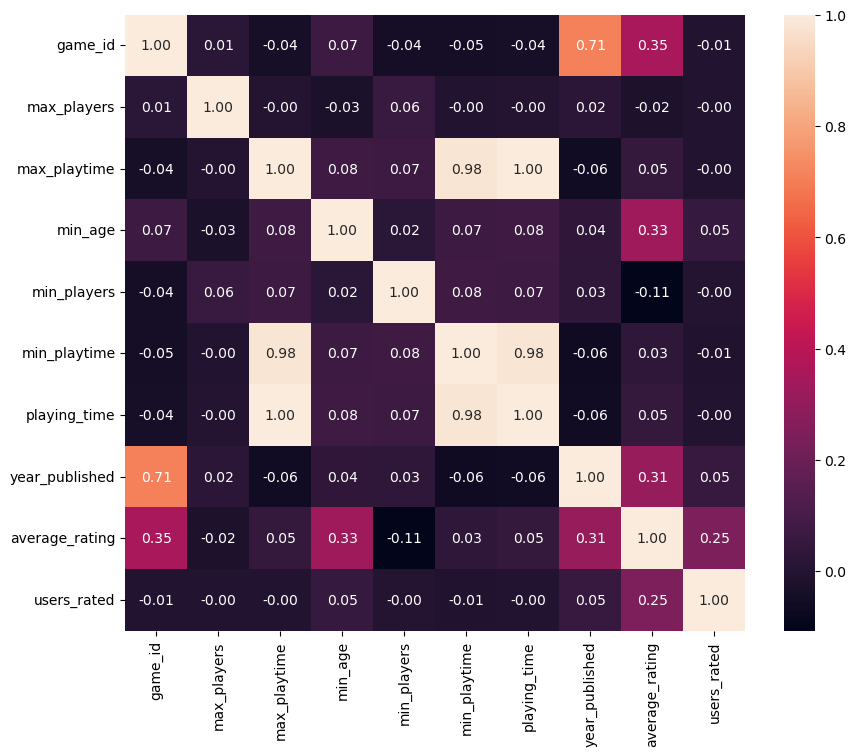

Correlation between average_rating and min_players: -0.11
Correlation between users_rated and average_rating: 0.25
Correlation between average_rating and year_published: 0.31
Correlation between average_rating and min_age: 0.33
Correlation between average_rating and game_id: 0.35
Correlation between year_published and game_id: 0.71
Correlation between min_playtime and max_playtime: 0.98
Correlation between playing_time and min_playtime: 0.98
Correlation between playing_time and max_playtime: 1.00


In [58]:
detect_correlations(filtered_numerical_df)

# Correlations, ignore anything with game_id:
                            average_rating to year_published  (interesting recency bias in ratings), 
                            average_rating to users_rated     (more ratings means more positive ratings)
                            average_rating to min_age         (higher ratings by adults)
                            average_rating to min_players     (weak negative for extra required players)

## A model may be possible to answer the million dollar question: "Is predict ratings?"

In [59]:
X = filtered_numerical_df[['year_published', 'users_rated', 'min_age', 'min_players']]
y = filtered_numerical_df['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bootstrapping
n_iterations = 1000  # Number of bootstrap samples to create
n_size = int(len(df) * 0.50)  # Size of each sample (50% of the dataset)

# Empty list to store model predictions
predictions = []

for i in range(n_iterations):
    # Prepare train and test sets
    X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=n_size)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_sample, y_train_sample)
    
    # Store errors to plot model accuracy
    y_pred_sample = model.predict(X_test)
    absolute_errors = np.abs(y_pred_sample - y_test)  # Calculate the absolute values of errors
    predictions.append(absolute_errors)

# Convert to array for calculation
predictions = np.array(predictions)

# Calculating 2.5th and 97.5th percentile to form the prediction interval
lower = np.percentile(predictions, 2.5, axis=0)
upper = np.percentile(predictions, 97.5, axis=0)

In [60]:
import statsmodels.api as sm

# Add a constant to the independent variable set to include the intercept term
X_with_const = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_with_const).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     680.2
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:26:24   Log-Likelihood:                -8321.5
No. Observations:                7712   AIC:                         1.665e+04
Df Residuals:                    7707   BIC:                         1.669e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -33.8782      1.312    -25.

## 26% of the variation in 'average_rating' can be explained by 'year_published', 'users_rated', and 'min_age'.

## ***Our linear model is 95% accurate to ±1 predicted ratings (see below).***

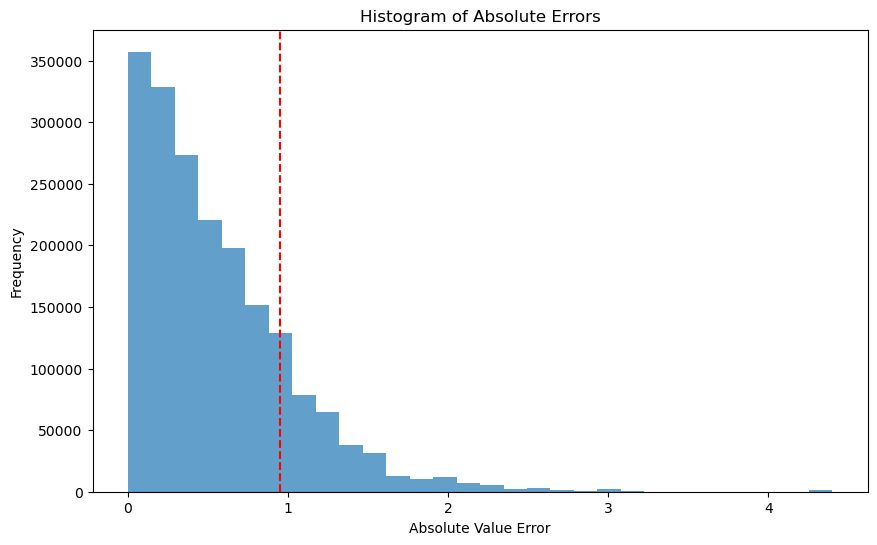

In [61]:
plt.figure(figsize=(10, 6))
plt.hist(predictions.flatten(), bins=30, alpha=0.7)
plt.axvline(x=0.95, color='r', linestyle='--')
plt.title('Histogram of Absolute Errors')
plt.xlabel('Absolute Value Error')
plt.ylabel('Frequency')
plt.show()

## We will make a ratings_bin, maybe classification approach will be better than regression.

## Phase 3: Sentiment Analysis
<br>

This portion of the code connects to the Reddit API using the PRAW Library. The PRAW Library requires a Reddit Developer Account to connect and requires authentication to access the API. The Library is a wrapper that stands for Python Reddit API Wrapper. The PRAW library was choosen because of it's ease of use to access data in the API.

We then find Reddit posts from the Boardgames subreddit that match the games from our dataset and run sentiment analysis on the posts.  Our hypothesis is that the games with the highest user ratings will have more positiveor negative reviews. 

In [67]:
#Import the praw library to connect to reddit using a developer account 

import praw

reddit = praw.Reddit(
    client_id="bDWKteHVap3FedLSOoZ-Bg",
    client_secret="rKk1k0PZxPdMz3Cxq03RaKKCh2J2Jw",
    password="Cocokhan1989",
    user_agent="project by u/Due_Tank2243",
    username="Due_Tank2243",
)

The below code will take create a new data frame that picks the top 10 games based on user ratings.

In [70]:


# Sort the DataFrame based on the 'players' column in descending order
sorted_games = BGG_data.sort_values(by='users_rated', ascending=False)

# Extract the 'name' column of the top 10 games
top_5_games_names = sorted_games.head(10)['name']


top_5_games_names.to_csv('gamestop.csv', index=False)

with open('gamestop.csv', 'r') as file:
    game_titles = file.readlines()

We then iterate over each game title to find a matching subreddit, skipping the first row since it's a header in the file. We then save the game name and comments from the subbreddit into a set which we then save to a dataframe to use later. 

In [73]:
headlines = set()

for game_title in game_titles[1:]:  # Exclude the first row
    for submission in reddit.subreddit('boardgames').search(game_title.strip()):
        headlines.add((game_title.strip(), submission.title))


In [74]:
#Create a dataframe from the scrapped data 
reddit_df = pd.DataFrame(headlines)
reddit_df



,0,1
0,7 Wonders,7 Wonders - Which Wonders do you like the most?
1,Agricola,Is Agricola still worth getting?
2,7 Wonders,"New to 7 Wonders, should I get 7 Wonders or 7 ..."
3,Power Grid,Power Grid Strategy
4,Agricola,Fun BGA Agricola Solo seed
...,...,...
993,Carcassonne,So this is what Carcassonne is actually like.
994,Puerto Rico,Is Puerto Rico overrated?
995,Agricola,Agricola rules question
996,Pandemic,pandemic legacy


In [75]:
#rename the columns for use in the functions 
reddit_df.columns = ['Games','Titles']


We then create a two seperate functions to clean the comments. The first function removes any links or mentions using regex. The second function then removes any emojis or pictures which can not be interpreted. This is necssary to remove any extra characters that could interfer with the sentiment analysis. 

In [79]:
def cleanTxt(text):
 text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
 text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
 text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
 text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
 text = re.sub(r':', '', text) # Remove :
 return text
#Cleaning the text
reddit_df['Titles']= reddit_df['Titles'].apply(cleanTxt)
#Show the clean text
reddit_df.head()

,Games,Titles
0,7 Wonders,7 Wonders - Which Wonders do you like the most?
1,Agricola,Is Agricola still worth getting?
2,7 Wonders,"New to 7 Wonders, should I get 7 Wonders or 7 ..."
3,Power Grid,Power Grid Strategy
4,Agricola,Fun BGA Agricola Solo seed


In [80]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#Cleaning the text
reddit_df["Titles"]= reddit_df["Titles"].apply(remove_emoji)

#Show the clean text
reddit_df.head()

,Games,Titles
0,7 Wonders,7 Wonders - Which Wonders do you like the most?
1,Agricola,Is Agricola still worth getting?
2,7 Wonders,"New to 7 Wonders, should I get 7 Wonders or 7 ..."
3,Power Grid,Power Grid Strategy
4,Agricola,Fun BGA Agricola Solo seed


We then create a function to get the subjectivity and polarity. We use subjectivity to understand how well the user is involved or invested in the subject. Polarity is the strength or intensity of their viewpoint. Polarity can be negative or positive and can be used to understand the sentiment of the post. 

In [81]:
#Create a function to get the subjectivity
def getSubjectivity(text):
 return TextBlob(text).sentiment.subjectivity
#Create a function to get Polarity
def getPolarity(text):
 return TextBlob(text).sentiment.polarity
#Now we create a new column for what we just did and add it to the  dataframe
reddit_df['Subjectivity'] = reddit_df['Titles'].apply(getSubjectivity)
reddit_df['Polarity'] = reddit_df['Titles'].apply(getPolarity)
#Now display data
reddit_df.head()

,Games,Titles,Subjectivity,Polarity
0,7 Wonders,7 Wonders - Which Wonders do you like the most?,0.500000,0.500000
1,Agricola,Is Agricola still worth getting?,0.100000,0.300000
2,7 Wonders,"New to 7 Wonders, should I get 7 Wonders or 7 ...",0.454545,0.136364
3,Power Grid,Power Grid Strategy,0.000000,0.000000
4,Agricola,Fun BGA Agricola Solo seed,0.200000,0.300000


We then created a new column based on the polarity, which we appended to the dataframe. The function below puts anything with a polarity below 0 as negative, anthing above 0 is positive and a score of 0 as neutral.  

In [82]:
#Group the range of Polarity into different categories
def getInsight(score):
 if score < 0:
     return 'Negative'
 elif score == 0:
     return 'Neutral'
 else:
     return 'Positive'
reddit_df['Insight'] = reddit_df['Polarity'].apply(getInsight)
reddit_df.head(50)

,Games,Titles,Subjectivity,Polarity,Insight
0,7 Wonders,7 Wonders - Which Wonders do you like the most?,0.500000,0.500000,Positive
1,Agricola,Is Agricola still worth getting?,0.100000,0.300000,Positive
2,7 Wonders,"New to 7 Wonders, should I get 7 Wonders or 7 ...",0.454545,0.136364,Positive
3,Power Grid,Power Grid Strategy,0.000000,0.000000,Neutral
4,Agricola,Fun BGA Agricola Solo seed,0.200000,0.300000,Positive
5,Pandemic,Asmodee USA announces price increase on 27 gam...,0.466667,0.033333,Positive
6,Puerto Rico,"Game of the Week, Redux, Redux Puerto Rico",0.400000,-0.400000,Negative
7,Small World,Small World,0.400000,-0.250000,Negative
8,Puerto Rico,"If I don't like Puerto Rico, then I won't like...",0.000000,0.000000,Neutral
9,Puerto Rico,Puerto Rico Captain Rule Battle,0.000000,0.000000,Neutral


A new variable is created in order to plot the insights per game.

In [83]:
games_gp = reddit_df.groupby(['Games', 'Insight']).count()

In [104]:
games_avg = reddit_df.groupby(['Games', 'Insight']).mean()
print(games_avg)

                         Subjectivity  Polarity
Games          Insight                         
7 Wonders      Negative      0.482500 -0.329167
               Neutral       0.037931  0.000000
               Positive      0.496565  0.370494
Agricola       Negative      0.389643 -0.247183
               Neutral       0.013953  0.000000
               Positive      0.383970  0.339967
Carcassonne    Negative      0.512422 -0.352352
               Neutral       0.022549  0.000000
               Positive      0.432442  0.411103
Catan          Negative      0.417753 -0.321396
               Neutral       0.077381  0.000000
               Positive      0.507745  0.403076
Dominion       Negative      0.513971 -0.343873
               Neutral       0.056494  0.000000
               Positive      0.482377  0.378969
Pandemic       Negative      0.485836 -0.341219
               Neutral       0.059798  0.000000
               Positive      0.490526  0.321612
Power Grid     Negative      0.582932 -0

Below the sentiment is plotted insight and also per game to understand if there are any trends. 

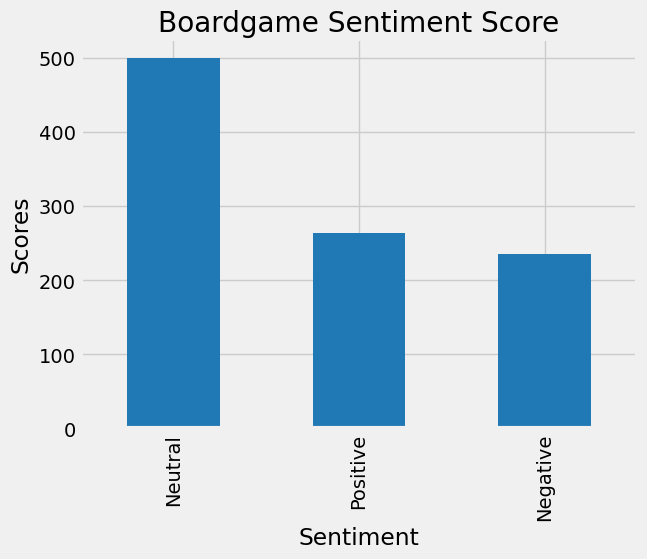

In [105]:
#Plot the values count of sentiment
plt.title("Boardgame Sentiment Score")
plt.xlabel("Sentiment")
plt.ylabel("Scores")
plt.rcParams["figure.figsize"] = (10,8)
reddit_df["Insight"].value_counts().plot(kind="bar", color="#2078B4")
plt.show()

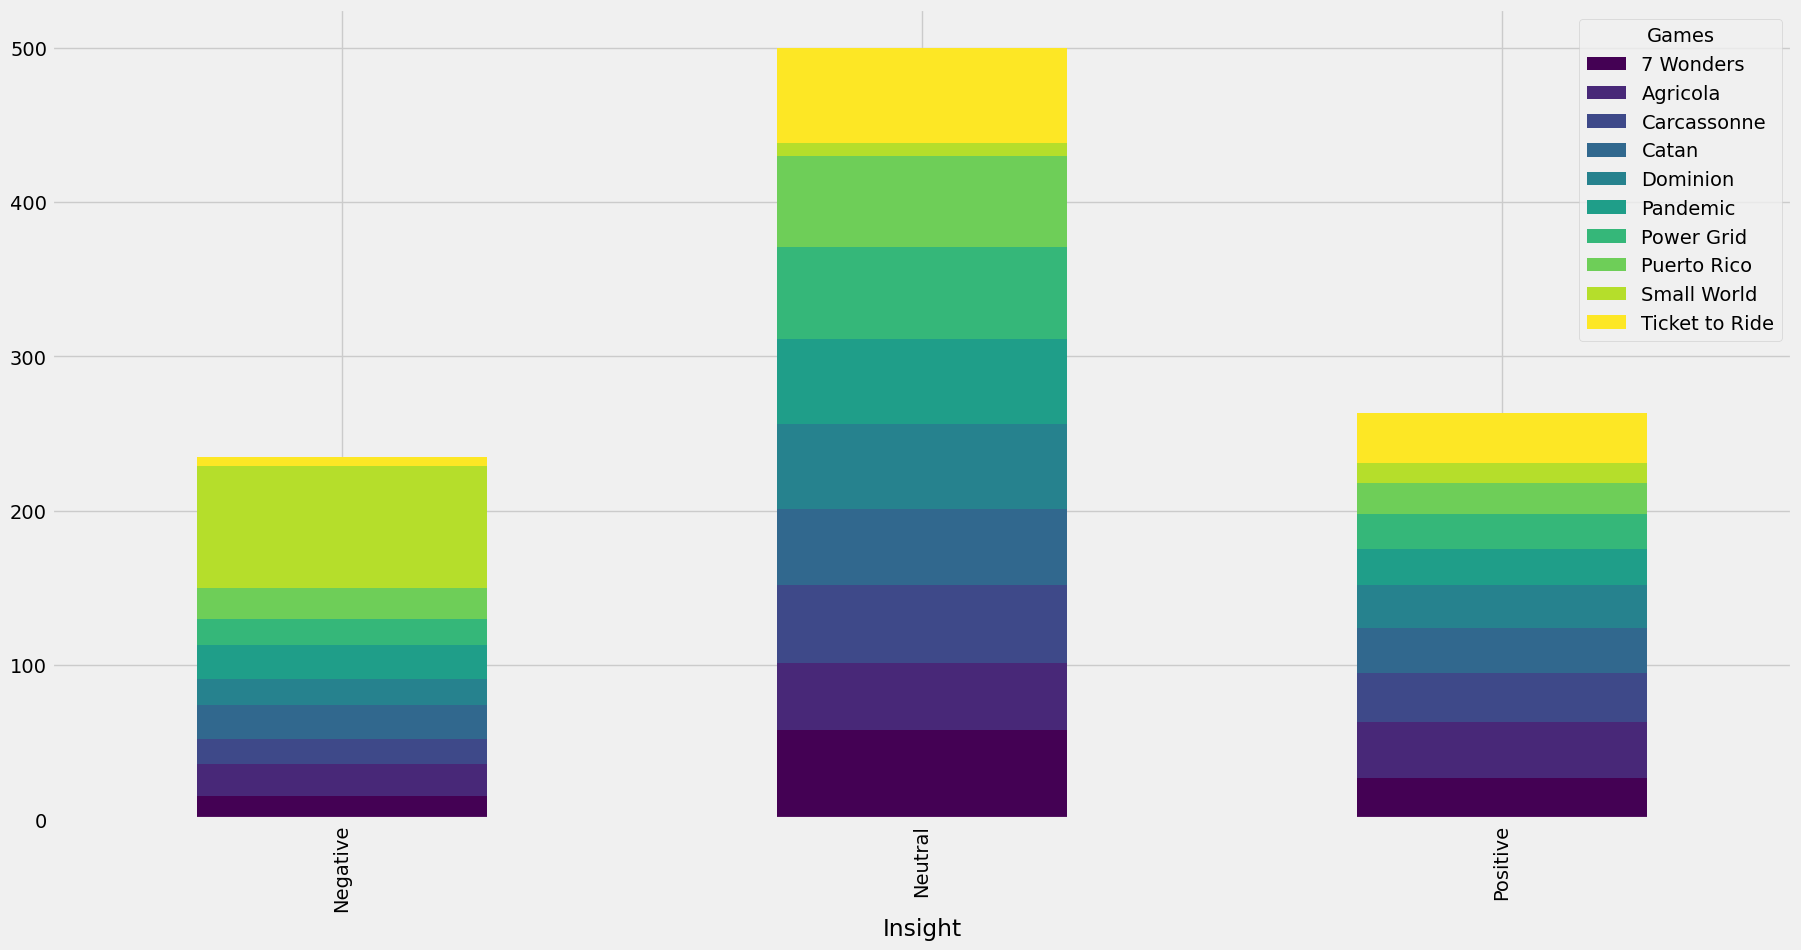

In [107]:

fig, ax = plt.subplots(figsize=(20, 10))

grouped_df_plt.plot(kind="bar", stacked=True, colormap="viridis", ax=ax)

plt.show()


## Conclusions
<br>
Our hypothesis of the most popular games having more positive/negative reviews is untrue. The majority of reivews are actually neutral. This could be because people turn to Reddit to ask questions or maybe strategy on how to play rather than providing reviews. Overall it was great to see the sentiment of different games!  

## Sources
<br>
Board Game Geek Dataset:
https://www.kaggle.com/datasets/sujaykapadnis/board-games
<br>
